In [1]:
# Standard code libraries
import sys
import copy
import scipy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import ipywidgets as widgets

import neurokit2 as nk
import random

%matplotlib widget

In [2]:
# Custom code libraries from the ReSurfEMG repository

from resurfemg.helper_functions.config import simulate_emg_with_occlusions
from resurfemg.data_connector.synthetic_data import simulate_ventilator_with_occlusions

import resurfemg.preprocessing.ecg_removal as ecg_rm
import resurfemg.preprocessing.envelope as evl
import resurfemg.preprocessing.filtering as filt

## 2. Simulate the ventilator and sEMG data

2.a Generate a patient and set the recording setting

In [3]:
# Experimemt settings
patient = 'HSP001'
measurement_date = 'XXXX_XX_XX_measurement_01'
recording_numbers = ['001', '002', '003', '004']
peep_steps = [3, 5, 7, 9]   # The PEEP steps to iterate (cmH2O)

# Recording parameters
t_rec = 7*60                # Recording duration (s)
fs_vent = 100               # Sampling rate of ventilator (Hz)
fs_emg = 2048               # Sampling rate of EMG amplifier (Hz)

# Ventilator parameters
dp = 8                      # Driving pressure above PEEP (cmH2O)  

# Patient respiratory variables
ie_ratio = 1/2              # Ratio between inspiratory and expiratory time
rr = 22                     # Respiratory rate (/min)
p_mus_max_0_PEEP = 10       # Maximal respiratory muscle pressure (cmH2O)
c = .050                    # Respiratory system compliance (L/cmH2O)
r = 5                       # Respiratory system resistance (cmH2O/L/s)
p_ip = -5                   # Static interpleural pressure (cmH2O)

tau_mus_up = 0.3            # Muscle contraction time constant
tau_mus_down = 0.3          # Muscle release time constant

# Cardiac parameters
hr_min = 60                 # Minimal heart rate (bpm)
hr_max = 100                # Maximal heart rate (bpm)

# Occlussion manoeuvre (Pocc) settings
t_occs = np.array([t_rec-45, t_rec-30, t_rec-15])
t_occs = np.floor(t_occs*rr/60)*60/rr   # Sync Poccs with respiratory pattern
for i, t_occ in enumerate(t_occs):
    if t_rec < (t_occ + 60/rr):
        print('t=' + str(t_occ) + ': t_occ should be at least a full '
              + 'respiratory cycle from t_end')
        
# Initialise expirement outputs
big_data_list = []
columns_now = ['patient', 'measurement', 'PEEP_set', 
                   'PTP_occs', 'ETP_di_occs', 'NMC_di', 
                   'SNR_di', 'PTP_occ_baseline', 'ETP_di_baseline', 
                   'ETP_di_baseline_old', 'ETP_di_bell_SE',
                   't_delta_di_med', 't_delta_ecg_med', 
                   't_Pocc_peak', 't_Pocc_start', 't_Pocc_end',
                   't_di_peak', 't_di_start', 't_di_end',
                   'dP_up_10', 'dP_up_90', 'dP_up_90_norm', 'double_dip'
               ]

df = pd.DataFrame(big_data_list, columns=columns_now)

2.b Select and set the next PEEP step

In [4]:
# Get the PEEP step index and the corresponding recording number and PEEP value
PEEP_idx = len(set(df['measurement'].values)) 
PEEP_step_chosen = recording_numbers[PEEP_idx]
peep = peep_steps[PEEP_idx]        # Positive end-expiratory pressure (cmH2O)

# Create a virtual trial effect:
#   Change the maximal tidal inspiratory pressure of the patient
p_mus_max = (1 - 0.049 * peep) * p_mus_max_0_PEEP 

print('The next PEEP step is:' 
      + '\nPatient: ' + patient
      + '\nMeasurement date: ' + measurement_date
      + '\nRecording: ' + PEEP_step_chosen 
      + '\nPEEP: ' + str(peep) + ' cmH2O')

The next PEEP step is:
Patient: HSP001
Measurement date: XXXX_XX_XX_measurement_01
Recording: 001
PEEP: 3 cmH2O


2.c Generate the ventilator and sEMG data for the next PEEP step

In [5]:
# Generate ECG data
hr = random.randint(hr_min, hr_max)
part_ecg = nk.ecg_simulate(duration=int(t_rec/1.5), 
                           sampling_rate=int(fs_emg*1.5), 
                           heart_rate=hr) 

print('The randomised heart rate is set at: ', hr, 'bpm')

The randomised heart rate is set at:  76 bpm


In [8]:
# Generate sEMGdi data
emg_di_part = simulate_emg_with_occlusions(
    t_p_occs=t_occs,
    t_start=0,
    t_end=t_rec,
    fs_emg=fs_emg,
    rr=rr,         
    ie_ratio=ie_ratio,
    tau_mus_up=0.3,
    tau_mus_down=0.3,
    emg_amp=5,     # Approximate EMG-RMS amplitude (uV)
    drift_amp=100, # Approximate drift RMS amplitude (uV)
    noise_amp=2    # Approximate baseline noise RMS amplitude (uV)
)

In [9]:
# Combine ECG and sEMGdi data
y_emg_remix = np.zeros((2, emg_di_part.shape[0]))
y_emg_remix[0] = 200 * part_ecg + 0.2 * emg_di_part     # The ECG channel
y_emg_remix[1] = 200 * part_ecg + 1.0 * emg_di_part     # The sEMGdi channel

In [13]:
y_vent = simulate_ventilator_with_occlusions(
    t_p_occs=t_occs,     # Timing of occlusions (s)
    t_start=0,
    t_end=t_rec,
    fs_vent=fs_vent,            # hertz
    rr=rr,                      # respiratory rate /min
    ie_ratio=ie_ratio,          # Ratio between inspiratory and expiratory time
    p_mus_max=p_mus_max,        # Maximal respiratory muscle pressure (cmH2O)
    tau_mus_up=tau_mus_up,      # Muscle contraction time constant
    tau_mus_down=tau_mus_down,  # Muscle release time constant
    c=c,                        # Respiratory system compliance (L/cmH2O)
    r=r,                        # Respiratory system resistance (cmH2O/L/s)
    peep=peep,                  # Positive end-expiratory pressure (cmH2O)
    dp=dp                       # Driving pressure above PEEP (cmH2O)
)

In [14]:
# Load the EMG and ventilator data recordings from the selected folders.
# data_emg = Poly5Reader(emg_file_chosen)
# data_vent = Poly5Reader(vent_file_chosen)
data_emg_samples = y_emg_remix
emg_fs = fs_emg
data_vent_samples = y_vent
vent_fs = fs_vent

# Define the time series of the EMG and ventilator recordings
y_emg = y_emg_remix
y_vent = y_vent

# Define the time axes
t_emg = [i/emg_fs for i in range(len(y_emg[0, :]))]
t_vent = [i/vent_fs for i in range(len(y_vent[0, :]))]

# Default settings for window of interest including the end-expiratory occlusion
# manoeuvres (Pocc)
t_start_default = t_vent[-1]-60
t_end_default = t_vent[-1]-5

Text(0.5, 0, 't (s)')

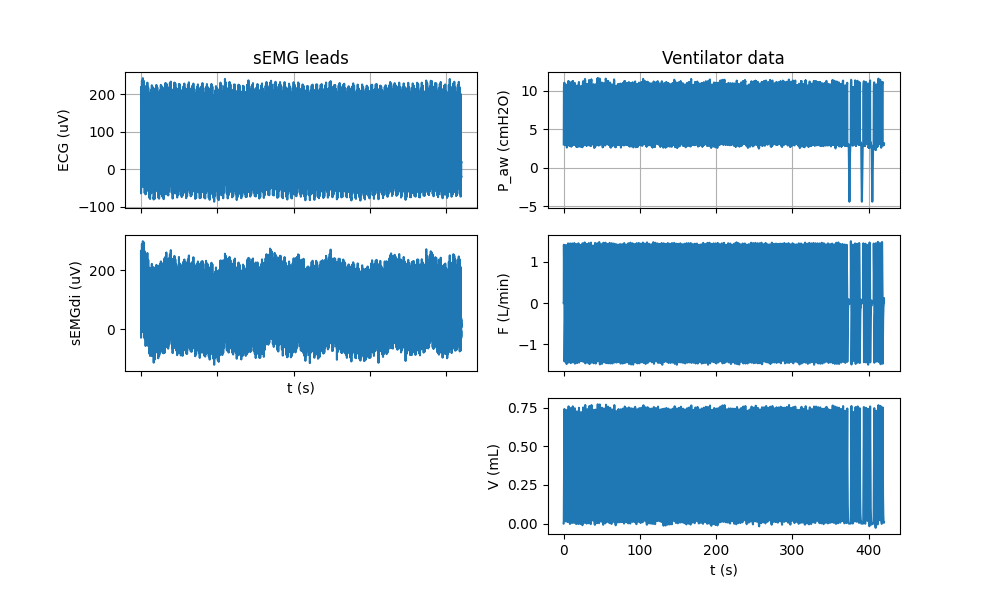

In [15]:
# Plot the raw data
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)

axis[0, 0].grid(True)
axis[0, 0].plot(t_emg, y_emg[0])
axis[0, 0].set(title='sEMG leads')
axis[0, 0].set_ylabel('ECG (uV)')
axis[1, 0].plot(t_emg, y_emg[1])
axis[1, 0].set_ylabel('sEMGdi (uV)')
axis[1, 0].set_xlabel('t (s)')
axis[2, 0].axis('off')

axis[0, 1].set(title='Ventilator data')
axis[0, 1].grid(True)
axis[0, 1].plot(t_vent, y_vent[0])
axis[0, 1].set_ylabel('P_aw (cmH2O)')
axis[1, 1].plot(t_vent, y_vent[1])
axis[1, 1].set_ylabel('F (L/min)')
axis[2, 1].plot(t_vent, y_vent[2])
axis[2, 1].set_ylabel('V (mL)')
axis[2, 1].set_xlabel('t (s)')

## 3. Select the time window of interest

Enter the start and end time of the window in which the occlusions occur. Make sure to take some margin around the peaks in the order of a couple of seconds to allow for the filtering algorithms to work properly. On the other hand, if the window is to broad, the algorithms will also take longer to evaluate.

In [16]:
# Window selection

start_widget = widgets.BoundedFloatText(
    value=np.floor(t_start_default),
    min=1,
    max=t_vent[-1],
    step=1,
    description='Start:',
    disabled=False
)
end_widget = widgets.BoundedFloatText(
    value=np.floor(t_end_default),
    min=1,
    max=t_vent[-1],
    step=1,
    description='End:',
    disabled=False
)
widgets.VBox([start_widget, end_widget])

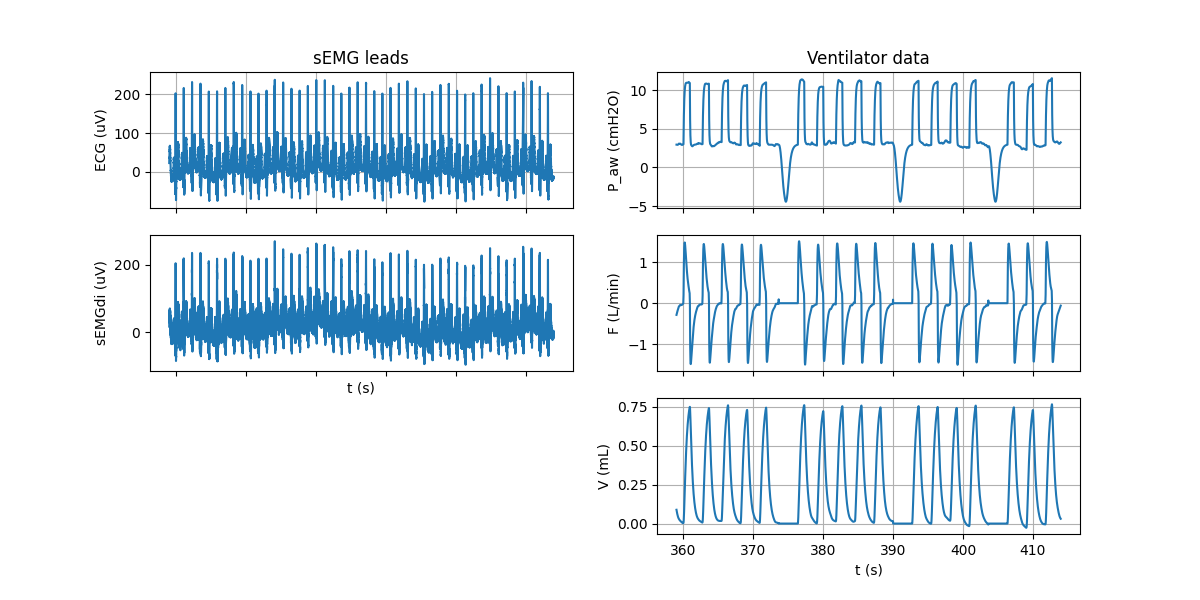

In [17]:
# Plot the selected window if valid start and end times are entered
start = start_widget.value  
end = end_widget.value  
if ((0 > start) | (t_vent[-1] < start) | (0 > end) | (t_vent[-1] < end) 
    | (start >= end)):    
    print('Please make sure that 1) the start and end times are within the'  
          +' limits of the recording and 2) that the start time is before the' 
          + ' end time.')
else:
    # Plot the selected window.
    start_idx = int(float(start)* emg_fs)
    end_idx = min([int(float(end)*emg_fs), len(y_emg[0,:])-1])
    start_vent_s = int(float(start)* vent_fs)
    end_vent_s = min(
        [int(float(end)* vent_fs), len(y_vent[0,:])-1]
    )

    fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(12, 6), sharex=True)

    axis[0, 0].set(title='sEMG leads')
    axis[0, 0].grid(True)
    axis[0, 0].plot(t_emg[int(start_idx):int(end_idx)], 
                    y_emg[0][int(start_idx):int(end_idx)])
    axis[0, 0].set_ylabel('ECG (uV)')
    axis[1, 0].plot(t_emg[int(start_idx):int(end_idx)], 
                    y_emg[1][int(start_idx):int(end_idx)])
    axis[1, 0].set_ylabel('sEMGdi (uV)')
    axis[1, 0].set_xlabel('t (s)')

    axis[2, 0].axis('off')

    axis[0, 1].set(title='Ventilator data')
    axis[0, 1].grid(True)
    axis[0, 1].plot(
        t_vent[int(start_vent_s):int(end_vent_s)], 
        y_vent[0][int(start_vent_s):int(end_vent_s)]
    )
    axis[0, 1].set_ylabel('P_aw (cmH2O)')
    axis[1, 1].grid(True)
    axis[1, 1].plot(
        t_vent[int(start_vent_s):int(end_vent_s)], 
        y_vent[1][int(start_vent_s):int(end_vent_s)]
    )
    axis[1, 1].set_ylabel('F (L/min)')
    axis[2, 1].grid(True)
    axis[2, 1].plot(
        t_vent[int(start_vent_s):int(end_vent_s)], 
        y_vent[2][int(start_vent_s):int(end_vent_s)]
    )
    axis[2, 1].set_ylabel('V (mL)')
    axis[2, 1].set_xlabel('t (s)')

## 4. Pre-process the sEMGdi

In [18]:
# Set the default pipeline parameters
# Gating settings
gate_width_default = 0.10
gate_threshold_default = 0.30
gate_ECG_shift_default = -10
gate_twice = False

# RMS window
RMS_window_ms_default = 200

# Peak detection settings
time_shift_default = 0.5 - RMS_window_ms_default/1000/2
P_occ_prominence_factor_default = 0.8
sEAdi_prominence_factor_default = 0.5

In [19]:
# Eliminate the baseline wander from the data using a band-pass filter
bd_filtered_file_data = filt.emg_bandpass_butter_sample(
    data_emg_samples, 1, 500, 2048, output='sos')
    
processed_data_emg_di = bd_filtered_file_data[1]

In [20]:
# Gating settings

# Window size to plot the gating results from
plot_window = 5         

# QRS peak detection settings
# peak_fraction = 0.30 (default value)
peak_fraction = gate_threshold_default     # Minimal relative peak height
peak_width = 0.001
peak_dist = int(emg_fs/3)

# Shift of gated in samples relative to detected peaks      
# ECG_shift = -10 (default value)
ECG_shift = gate_ECG_shift_default

# Gate width in seconds
# gate_width = 0.10 (default value)
gate_width = gate_width_default

Apply QRS gating

In [21]:
# First run of QRS gating

# Detect ECG peaks on 1Hz high-pass filtered signals
ecg = bd_filtered_file_data[0]
ecg_rms = evl.full_rolling_rms(ecg, 10)
max_ecg_rms = max(
    ecg_rms[int(start_idx):int(start_idx+plot_window*emg_fs)])
min_ecg_rms = min(
    ecg_rms[int(start_idx):int(start_idx+plot_window*emg_fs)])
peak_height = peak_fraction*(max_ecg_rms - min_ecg_rms)

ECG_peaks, properties  = scipy.signal.find_peaks(
    ecg_rms, 
    height=peak_height, 
    width=peak_width*emg_fs, 
    distance=peak_dist
)

# The RMS filter is not centred. Therefore, shift the ECG peak locations
ECG_peaks = ECG_peaks - ECG_shift

# Filter EXG signals 20Hz high pass
ECG_h20 = filt.emg_bandpass_butter_sample(ecg, 20, 500, 2048, output='sos')
emg_di_h20 = filt.emg_bandpass_butter_sample(
    processed_data_emg_di, 20, 500, 2048, output='sos')

# Gate ECG and EMG signal
# Fill methods 0: Zeros, 1: Interpolate start-end, 2: Average prior data, 
# 3: Moving average
gate_fill_method = 3    
gate_width_samples = int(gate_width*emg_fs)

gate_samples = list()
for i in range(len(ECG_peaks)):
    for k in range(
        int(ECG_peaks[i]-gate_width_samples/2),
        int(ECG_peaks[i]+gate_width_samples/2)
    ):
        gate_samples.append(k)

ECG_gated = ecg_rm.gating(
    ECG_h20, ECG_peaks, gate_width=gate_width_samples, method=3)
emg_di_gated = ecg_rm.gating(
    emg_di_h20, ECG_peaks, gate_width=gate_width_samples, method=3)


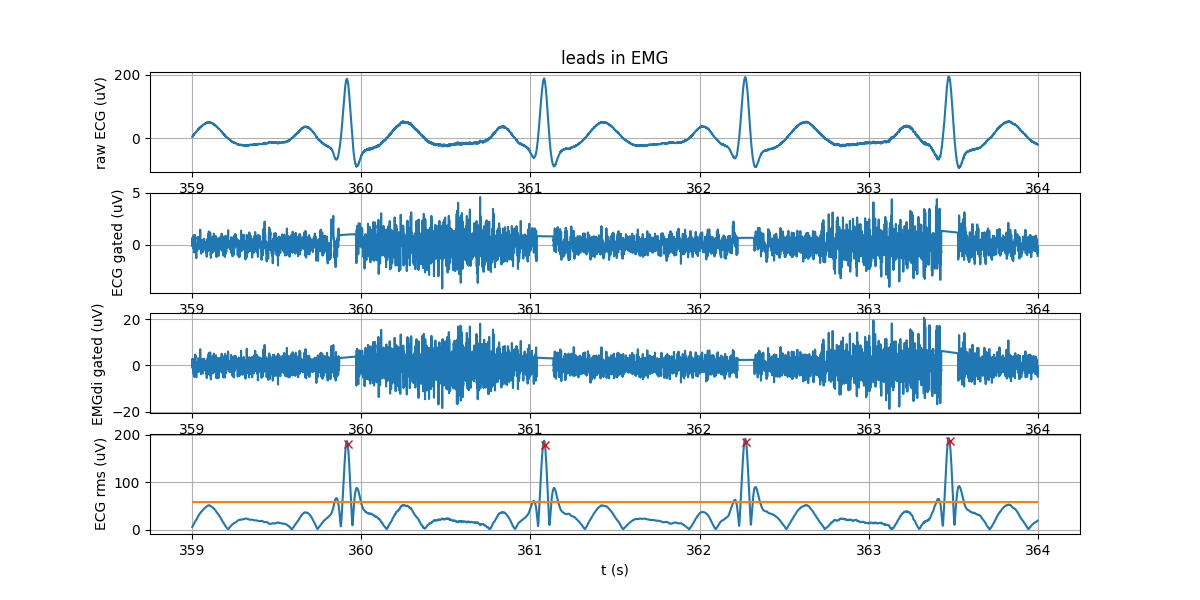

In [22]:
# Plot gating result
fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(12, 6))
start_i = int(start_idx)
end_i = int(start_idx+plot_window*2048)
axis[0].grid(True)
axis[0].plot(t_emg[start_i:end_i], bd_filtered_file_data[0, start_i:end_i])
axis[0].set_ylabel('raw ECG (uV)')
axis[0].set(title='leads in EMG')
axis[1].grid(True)
axis[1].plot(t_emg[start_i:end_i], ECG_gated[start_i:end_i])
axis[1].set_ylabel('ECG gated (uV)')
axis[2].grid(True)
axis[2].plot(t_emg[start_i:end_i], emg_di_gated[start_i:end_i])
axis[2].set_ylabel('EMGdi gated (uV)')
axis[3].grid(True)
axis[3].plot(t_emg[start_i:end_i], ecg_rms[start_i:end_i])
axis[3].set_ylabel('ECG rms (uV)')
axis[3].hlines(
    y=peak_height, 
    xmin=t_emg[start_i], 
    xmax=t_emg[end_i],
    color = "C1"
)
axis[3].set_xlabel('t (s)')

for idx in range(len(ECG_peaks)):
    if ((ECG_peaks[idx] > int(start_idx)) 
        & (ECG_peaks[idx] < int(start_idx+plot_window*2048))):
        axis[3].plot(t_emg[ECG_peaks[idx]], ecg_rms[ECG_peaks[idx]],'rx')


In [23]:
# Repeat QRS complex just before peak at t=359.9s

ECG_peaks_new = np.append(ECG_peaks, ECG_peaks[ECG_peaks>start_i][0]-gate_width_samples)
ECG_peaks_new = np.append(ECG_peaks_new, ECG_peaks[ECG_peaks>start_i][0]+gate_width_samples)
ECG_peaks_new.sort()


In [24]:
# Gate ECG and EMG signal
# Fill methods 0: Zeros, 1: Interpolate start-end, 2: Average prior data, 
# 3: Moving average
gate_fill_method = 3    
gate_width_samples = int(gate_width*emg_fs)

gate_samples = list()
for i in range(len(ECG_peaks)):
    for k in range(
        int(ECG_peaks[i]-gate_width_samples/2),
        int(ECG_peaks[i]+gate_width_samples/2)
    ):
        gate_samples.append(k)

gating_method = 3
ECG_gated = ecg_rm.gating(
    ECG_h20, ECG_peaks_new, gate_width=gate_width_samples, method=gating_method)
emg_di_gated = ecg_rm.gating(
    emg_di_h20, ECG_peaks_new, gate_width=gate_width_samples, method=gating_method)

In [25]:
def gating_old(
    src_signal,
    gate_peaks,
    gate_width=205,
    method=1,
):
    """
    Eliminate peaks (e.g. QRS) from src_signal using gates
    of width gate_width. The gate either filled by zeros or interpolation.
    The filling method for the gate is encoded as follows:
    0: Filled with zeros
    1: Interpolation samples before and after
    2: Fill with average of prior segment if exists
    otherwise fill with post segment
    3: Fill with running average of RMS (default)

    :param src_signal: Signal to process
    :type src_signalsignal: ~numpy.ndarray
    :param gate_peaks: list of individual peak index places to be gated
    :type gate_peaks: ~list
    :param gate_width: width of the gate
    :type gate_width: int
    :param method: filling method of gate
    :type method: int

    :returns: src_signal_gated, the gated result
    :rtype: ~numpy.ndarray
    """
    src_signal_gated = copy.deepcopy(src_signal)
    max_sample = src_signal_gated.shape[0]
    half_gate_width = gate_width // 2
    if method == 0:
        # Method 0: Fill with zeros
        # TODO: can rewrite with slices from numpy irange to be more efficient
        gate_samples = []
        for _, peak in enumerate(gate_peaks):
            for k in range(
                max(0, peak - half_gate_width),
                min(max_sample, peak + half_gate_width),
            ):
                gate_samples.append(k)

        src_signal_gated[gate_samples] = 0
    elif method == 1:
        # Method 1: Fill with interpolation pre- and post gate sample
        # TODO: rewrite with numpy interpolation for efficiency
        for _, peak in enumerate(gate_peaks):
            pre_ave_emg = src_signal[peak-half_gate_width-1]

            if (peak + half_gate_width + 1) < src_signal_gated.shape[0]:
                post_ave_emg = src_signal[peak+half_gate_width+1]
            else:
                post_ave_emg = 0

            k_start = max(0, peak-half_gate_width)
            k_end = min(
                peak+half_gate_width, src_signal_gated.shape[0]
            )
            for k in range(k_start, k_end):
                frac = (k - peak + half_gate_width)/gate_width
                loup = (1 - frac) * pre_ave_emg + frac * post_ave_emg
                src_signal_gated[k] = loup

    elif method == 2:
        # Method 2: Fill with window length mean over prior section
        # ..._____|_______|_______|XXXXXXX|XXXXXXX|_____...
        #         ^               ^- gate start   ^- gate end
        #         - peak - half_gate_width * 3 (replacer)

        for _, peak in enumerate(gate_peaks):
            start = peak - half_gate_width * 3
            if start < 0:
                start = peak + half_gate_width
            end = start + gate_width
            pre_ave_emg = np.nanmean(src_signal[start:end])

            k_start = max(0, peak - half_gate_width)
            k_end = min(peak + half_gate_width, src_signal_gated.shape[0])
            for k in range(k_start, k_end):
                src_signal_gated[k] = pre_ave_emg

    elif method == 3:
        # Method 3: Fill with moving average over RMS
        gate_samples = []
        for _, peak in enumerate(gate_peaks):
            for k in range(
                max([0, int(peak-gate_width/2)]),
                min([max_sample, int(peak+gate_width/2)])
            ):
                gate_samples.append(k)

        src_signal_gated_base = copy.deepcopy(src_signal_gated)
        src_signal_gated_base[gate_samples] = np.NaN
        src_signal_gated_rms = evl.full_rolling_rms(
            src_signal_gated_base,
            gate_width,)

        for _, peak in enumerate(gate_peaks):
            k_start = max([0, int(peak-gate_width/2)])
            k_end = min([int(peak+gate_width/2), max_sample])

            for k in range(k_start, k_end):
                leftf = max([0, int(k-1.5*gate_width)])
                rightf = min([int(k+1.5*gate_width), max_sample])
                src_signal_gated[k] = np.nanmean(
                    src_signal_gated_rms[leftf:rightf]
                )
                

    return src_signal_gated

In [26]:
# Gate ECG and EMG signal
# Fill methods 0: Zeros, 1: Interpolate start-end, 2: Average prior data, 
# 3: Moving average
gate_fill_method = 3    
gate_width_samples = int(gate_width*emg_fs)

gate_samples = list()
for i in range(len(ECG_peaks)):
    for k in range(
        int(ECG_peaks[i]-gate_width_samples/2),
        int(ECG_peaks[i]+gate_width_samples/2)
    ):
        gate_samples.append(k)

gating_method = 3
ECG_gated_old = gating_old(
    ECG_h20, ECG_peaks_new, gate_width=gate_width_samples, method=gating_method)
emg_di_gated_old = gating_old(
    emg_di_h20, ECG_peaks_new, gate_width=gate_width_samples, method=gating_method)

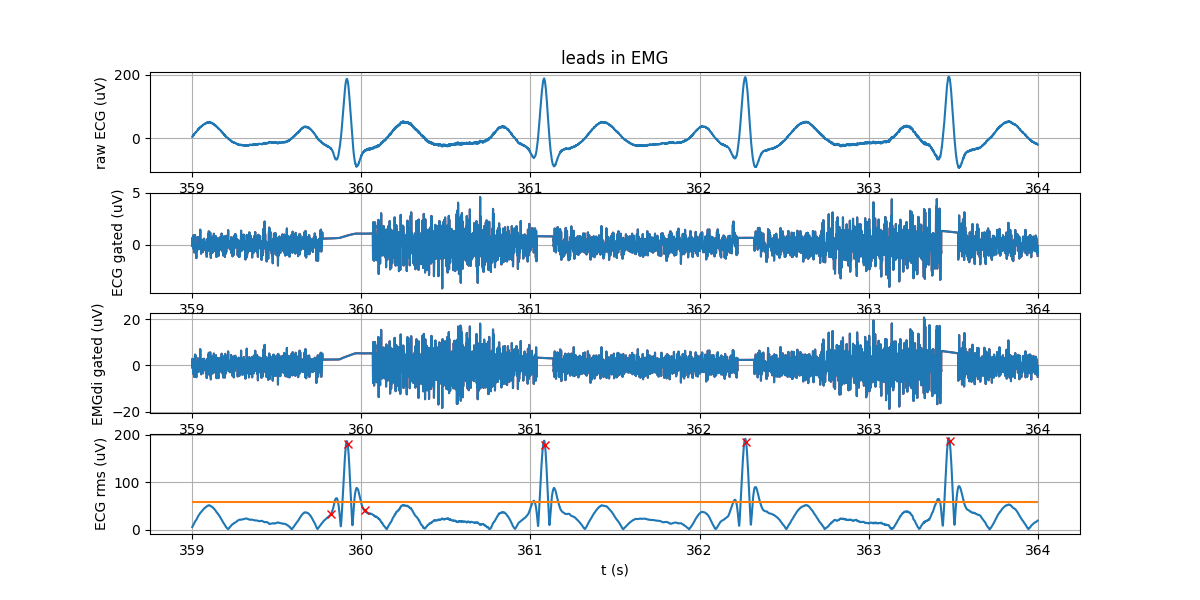

In [29]:
# Plot gating result
fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(12, 6))
start_i = int(start_idx)
end_i = int(start_idx+plot_window*2048)
axis[0].grid(True)
axis[0].plot(t_emg[start_i:end_i], bd_filtered_file_data[0, start_i:end_i])
axis[0].set_ylabel('raw ECG (uV)')
axis[0].set(title='leads in EMG')
axis[1].grid(True)
axis[1].plot(t_emg[start_i:end_i], ECG_gated[start_i:end_i], color='tab:red')
axis[1].plot(t_emg[start_i:end_i], ECG_gated_old[start_i:end_i], color='tab:blue')
axis[1].set_ylabel('ECG gated (uV)')
axis[2].grid(True)
axis[2].plot(t_emg[start_i:end_i], emg_di_gated[start_i:end_i], color='tab:red')
axis[2].plot(t_emg[start_i:end_i], emg_di_gated_old[start_i:end_i], color='tab:blue')
axis[2].set_ylabel('EMGdi gated (uV)')
axis[3].grid(True)
axis[3].plot(t_emg[start_i:end_i], ecg_rms[start_i:end_i])
axis[3].set_ylabel('ECG rms (uV)')
axis[3].hlines(
    y=peak_height, 
    xmin=t_emg[start_i], 
    xmax=t_emg[end_i],
    color = "C1"
)
axis[3].set_xlabel('t (s)')

for idx in range(len(ECG_peaks_new)):
    if ((ECG_peaks_new[idx] > int(start_idx)) 
        & (ECG_peaks_new[idx] < int(start_idx+plot_window*2048))):
        axis[3].plot(t_emg[ECG_peaks_new[idx]], ecg_rms[ECG_peaks_new[idx]],'rx')
